In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

In [2]:
from mtcnn.mtcnn import MTCNN

In [3]:
images=os.path.join(r"C:\Users\hp\OneDrive\Desktop\archive\Medical mask\Medical mask\Medical Mask\images")
annotations=os.path.join(r"C:\Users\hp\OneDrive\Desktop\archive\Medical mask\Medical mask\Medical Mask\annotations")
train=pd.read_csv(os.path.join(r"C:\Users\hp\OneDrive\Desktop\archive\train.csv"))
submission=pd.read_csv(os.path.join(r"C:\Users\hp\OneDrive\Desktop\archive\submission.csv"))

In [4]:
print(len(train))
train.head()

15412


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [5]:
print(len(submission))
submission.head()

8142


,name,x1,x2,y1,y2,classname
0,1800.jpg,NaN,NaN,NaN,NaN,NaN
1,1800.jpg,NaN,NaN,NaN,NaN,NaN
2,1800.jpg,NaN,NaN,NaN,NaN,NaN
3,1799.jpg,NaN,NaN,NaN,NaN,NaN
4,1799.jpg,NaN,NaN,NaN,NaN,NaN


In [6]:
len(os.listdir(images))

6024

In [7]:
a=os.listdir(images)
b=os.listdir(annotations)
a.sort()
b.sort()

In [8]:
print(len(b),len(a))

4326 6024


In [9]:
train_images=a[1698:]
test_images=a[:1698]

In [10]:
test_images[9]

'0011.jpg'

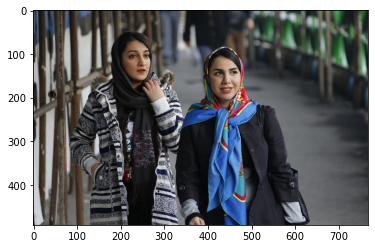

In [11]:
img=plt.imread(os.path.join(images,test_images[9]))
plt.imshow(img)
plt.show()

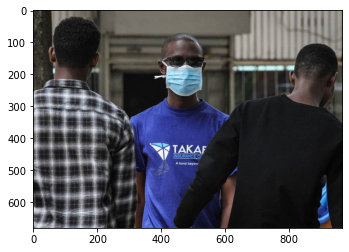

In [12]:
img=plt.imread(os.path.join(images,train_images[21]))
plt.imshow(img)
plt.show()

In [13]:
options=['face_with_mask','face_no_mask']
train= train[train['classname'].isin(options)]
train.sort_values('name',axis=0,inplace=True)

[]


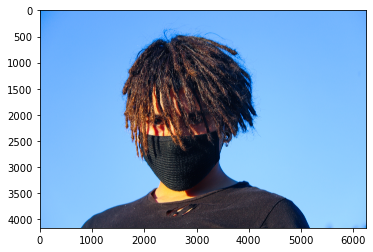

In [14]:
bbox=[]
for i in range(len(train)):
    arr=[]
    for j in train.iloc[i][["x1",'x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train["bbox"]=bbox  
def get_boxes(id):
    boxes=[]
    for i in train[train["name"]==str(id)]["bbox"]:
        boxes.append(i)
    return boxes
print(get_boxes(train_images[67]))
image=train_images[67]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

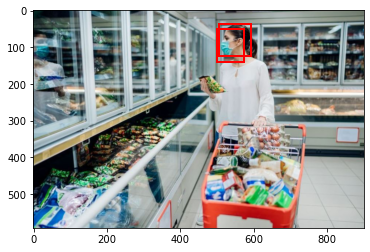

In [15]:
image=train_images[100]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

<BarContainer object of 2 artists>

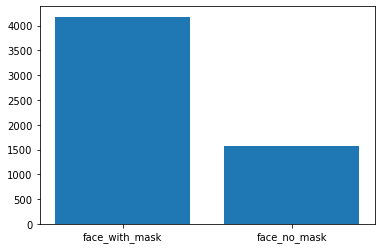

In [16]:
plt.bar(['face_with_mask','face_no_mask'],train.classname.value_counts())

In [20]:
img_size=50
data=[]
path=r"C:\Users\hp\OneDrive\Desktop\archive\Medical mask\Medical mask\Medical Mask\images"
def create_data():
       for i in range(len(train)):
            arr=[]
            for j in train.iloc[i]:
                   arr.append(j)
            img_array=cv2.imread(os.path.join(images,arr[0]),cv2.IMREAD_GRAYSCALE)
            crop_image = img_array[arr[2]:arr[4],arr[1]:arr[3]]
            new_img_array=cv2.resize(crop_image,(img_size,img_size))
            data.append([new_img_array,arr[5]])
create_data()      

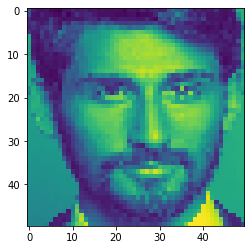

In [21]:
data[0][0]
plt.imshow(data[0][0])

In [22]:
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
y=lbl.fit_transform(y)

In [23]:
x=np.array(x).reshape(-1,50,50,1)
x=tf.keras.utils.normalize(x,axis=1)
from keras.utils import to_categorical
y = to_categorical(y)

In [24]:
from keras.layers import LSTM
model=Sequential()
model.add(Conv2D(100,(3,3),input_shape=x.shape[1:],activation='relu',strides=2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

C:\Users\hp\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x, y, epochs=30, batch_size=5)


Epoch 1/30


C:\Users\hp\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1150/1150 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7272 - loss: 0.5772
Epoch 2/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7308 - loss: 0.4874
Epoch 3/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7923 - loss: 0.4360
Epoch 4/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8277 - loss: 0.4149
Epoch 5/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8297 - loss: 0.3911
Epoch 6/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8375 - loss: 0.3552
Epoch 7/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8516 - loss: 0.3382
Epoch 8/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8702 - loss: 0.3066
Epoch 9/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8847 - loss: 0.2801
Epoch 10/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8907 - loss: 0.2564
Epoch 11/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9006 - loss: 0.2484
Epoch 12/30
1150/1150 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


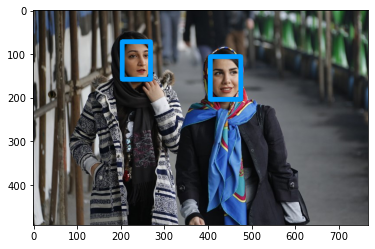

In [28]:
detector=MTCNN()
img=plt.imread(os.path.join(images,test_images[9]))
face=detector.detect_faces(img)
for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              10)
        plt.imshow(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


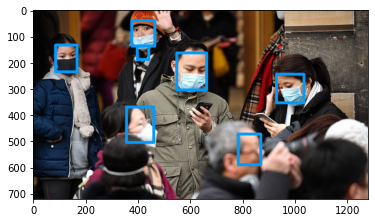

In [29]:
img=plt.imread(os.path.join(images,test_images[21]))
face=detector.detect_faces(img)
for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              10)
        plt.imshow(x)

In [32]:
negative=[]
for i in test:
    for j in i[1]:
        if j<0:
            negative.append(i)

In [33]:
test_data=[]
def create_test_data():
            for j in test:
                if j not in negative:
                    img=cv2.imread(os.path.join(images,j[0]),cv2.IMREAD_GRAYSCALE)
                    img=img[j[1][1]:j[1][1]+j[1][3],j[1][0]:j[1][0]+j[1][2]]
                    new_img=cv2.resize(img,(50,50))
                    new_img=new_img.reshape(-1,50,50,1)
                    predict=model.predict(new_img)
                    test_data.append([j,predict])

create_test_data()      

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [34]:
image=[]
classname=[]
for i,j in test_data:
    classname.append(np.argmax(j))
    image.append(i)
df=pd.DataFrame(columns=['image','classname'])
df['image']=image
df['classname']=classname
df['classname']=lbl.inverse_transform(df['classname'])
image=[]
x1=[]
x2=[]
y1=[]
y2=[]
for i in df['image']:
    image.append(i[0])
    x1.append(i[1][0])
    x2.append(i[1][1])
    y1.append(i[1][2])
    y2.append(i[1][3])
df['name']=image
df['x1']=x1
df['x2']=x2
df['y1']=y1
df['y2']=y2    
df.drop(['image'],axis=1,inplace=True)


In [35]:
df.sort_values('name',axis=0,inplace=True,ascending=False)
df.to_csv('submission_1.csv')
